In [34]:
wlist = ["time", "prepare", "solution", "make", "mistake", "no", "the", "probable", "long", "lecture", "method", "disaster", "fail",
"work", "advice", "idea", "succeed", "easy", "is", "for", "give"]
wdir = "words"

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pyttsx3
import scipy
import copy
import librosa
plt.style.use('ggplot')

In [36]:
def load_txt(path="Signal1.txt"):
    return np.loadtxt(path)
def text_to_speech(text, output_file):
    engine = pyttsx3.init()
    engine.save_to_file(text, "temp.wav")
    engine.runAndWait()
    os.rename("temp.wav", output_file)
def signal_to_wav(data, path, sr=22050): 
    scipy.io.wavfile.write(path, sr, data)
def load_word(path):
    sr, sig = scipy.io.wavfile.read(path)
    sig, _, _ = strim(sig)
    return sig.astype(np.float64), sr
def strim(s1, trim_threshold=50):
    # Set elements within the range (-trim_threshold, trim_threshold) to 0
    s1[np.abs(s1) < trim_threshold] = 0
    # Count the number of zeros trimmed from the start and end
    start_trimmed, end_trimmed = np.count_nonzero(s1[:len(s1)//2] == 0), np.count_nonzero(s1[len(s1)//2:] == 0)
    # Trim zeros from the signal and return the trimmed signal along with counts
    return np.trim_zeros(s1), start_trimmed, end_trimmed
def split_data(data, window_size=1000, threshold=1600):
    # Make a deep copy to avoid modifying the original data
    data = copy.deepcopy(data)
    #data[data < threshold] = 0
    # Initialize variables
    base, is_voice, n_empty = 0, False, 0
    # Calculate the padded size for the data
    msize, psize = data.size, (data.size // window_size + 1) * window_size
    data = np.pad(data, (0, psize - data.size))
    # Lists to store the segmented parts and their corresponding regions
    parts, regions = [], []
    # Iterate through windows of the padded data
    for i, window in enumerate(np.array_split(data, msize // window_size + 1)):
        # Calculate the maximum value in the current window
        max_value = np.max(np.abs(window))
        # Check if there are enough empty windows after voice activity
        if n_empty > 1 and is_voice:
            # Trim the signal and append it to the parts list
            part, st, et = strim(data[base:(i + 1) * window_size], 10)
            parts.append(part)
            # Store the region of the trimmed signal
            regions.append((base + st, base + st + part.size))
            # Update the base, reset voice flag, and reset empty count
            base, is_voice, n_empty = (i + 1) * window_size, False, 0
        # Check for the start of voice activity
        elif max_value >= threshold and not is_voice:
            is_voice = True
        # Check for the end of voice activity
        elif max_value < threshold and is_voice:
            n_empty += 1
    # If no parts were extracted, return the original data as a single part
    return ([data], None) if not parts else (parts, regions)
def spad(s1, s2):
    # Trim the signals using the trim_signal function
    trimmed_s1, _, _ = strim(s1)
    trimmed_s2, _, _ = strim(s2)
    # Determine the maximum size between the two trimmed signals
    max_size = max(trimmed_s1.size, trimmed_s2.size)
    # Calculate the padded size, ensuring it's a multiple of 1000
    padded_size = ((max_size // 1000) + 1) * 1000
    # Pad the signals to the calculated padded size
    padded_s1 = np.pad(trimmed_s1, (0, padded_size - trimmed_s1.size))
    padded_s2 = np.pad(trimmed_s2, (0, padded_size - trimmed_s2.size))
    
    # Return the padded signals
    return padded_s1, padded_s2
def compute_spectral_distance(featureX, featureY):
    dist, _, _ = scipy.spatial.distance.directed_hausdorff(featureX, featureY)
    return dist
def compute_audio_features(y, sr, n_fft=2048):
    sY = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft)
    mfccsY = librosa.feature.mfcc(S=librosa.power_to_db(sY))
    scY = librosa.feature.spectral_centroid(y=y, n_fft=n_fft)
    chromaY = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft)    
    return mfccsY, scY, chromaY
def wstats(sim, write=True, percent=False):
        guess = sorted(sim, key=lambda x: x[1])[:3]
        total = 0
        for (_, n) in guess:
            total += n
        g = []
        for (w, p) in guess:
            g.append((w, round(total/p*10,1)))
        return g

In [37]:
# Ensure the output directory exists
os.makedirs(wdir, exist_ok=True)
# Generate WAV files for each word
for word in wlist:
    output_file = os.path.join(wdir, f"{word}.wav")
     # Check if WAV file already exists
    if not os.path.exists(output_file):
        text_to_speech(word, output_file)
        print(f"WAV file generated for '{word}': {output_file}")
    else:
        print(f"WAV file for '{word}' already exists: {output_file}")

WAV file for 'time' already exists: words\time.wav
WAV file for 'prepare' already exists: words\prepare.wav
WAV file for 'solution' already exists: words\solution.wav
WAV file for 'make' already exists: words\make.wav
WAV file for 'mistake' already exists: words\mistake.wav
WAV file for 'no' already exists: words\no.wav
WAV file for 'the' already exists: words\the.wav
WAV file for 'probable' already exists: words\probable.wav
WAV file for 'long' already exists: words\long.wav
WAV file for 'lecture' already exists: words\lecture.wav
WAV file for 'method' already exists: words\method.wav
WAV file for 'disaster' already exists: words\disaster.wav
WAV file for 'fail' already exists: words\fail.wav
WAV file for 'work' already exists: words\work.wav
WAV file for 'advice' already exists: words\advice.wav
WAV file for 'idea' already exists: words\idea.wav
WAV file for 'succeed' already exists: words\succeed.wav
WAV file for 'easy' already exists: words\easy.wav
WAV file for 'is' already exists

In [38]:
words = []
for word in wlist:
    input_file = os.path.join(wdir, f"{word}.wav")
    sig, sr = load_word(input_file)
    words.append((word,sig,sr))

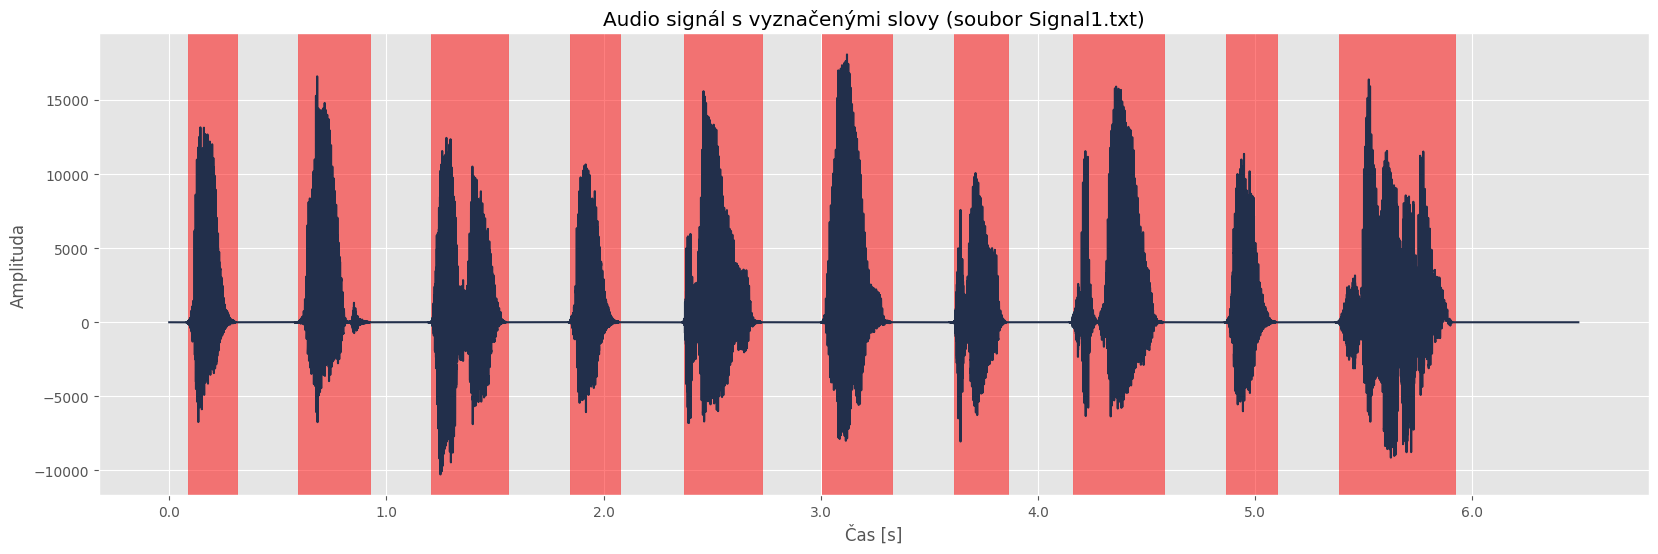

In [39]:
data = load_txt()
parts, regions = split_data(data)

plt.figure(figsize=(20, 6))
plt.plot(data, color="#222F4B")
for i, (start, end) in enumerate(regions):
    color = "red"
    plt.axvspan(start, end, color=color, alpha=0.5)
plt.xticks(np.arange(0, len(data), 22050), np.round(np.arange(0, len(data), 22050)/22050, 1))
plt.xlabel("Čas [s]")
plt.ylabel("Amplituda")
plt.title("Audio signál s vyznačenými slovy (soubor Signal1.txt)")

plt.show()

In [40]:
for Y in parts:
    similarities = []
    for (word, X, srX) in words:
        pX, pY = spad(X, Y)
        # Compute features for reference audio
        mfccsX, scX, chromaX = compute_audio_features(pX, srX)
        # Compute features for target audio
        mfccsY, scY, chromaY = compute_audio_features(pY, 22050)
        # Compute distances
        dist_mfccs = compute_spectral_distance(mfccsX, mfccsY)
        dist_sc = compute_spectral_distance(scX, scY)
        dist_chroma = compute_spectral_distance(chromaX, chromaY)
        #print(dist_mfccs, dist_sc, dist_chroma)
        # Combine distances with weights
        similarity = (dist_mfccs + dist_sc * 0.25 + dist_chroma * 0.1)
        similarities.append((word, similarity))
    
    print(*wstats(similarities))
    # Select the top 3 guesses
    guess = sorted(similarities, key=lambda x: x[1])[:3]
    guess = [(x[0], np.round(x[1], 2)) for x in guess]

('the', 80.8) ('no', 29.2) ('easy', 18.7)
('work', 66.9) ('make', 35.1) ('no', 17.7)
('easy', 85.0) ('idea', 25.2) ('make', 20.6)
('the', 67.0) ('no', 31.7) ('long', 18.7)
('time', 63.9) ('give', 23.9) ('easy', 23.6)
('no', 41.7) ('work', 28.4) ('make', 24.5)
('the', 38.9) ('no', 27.0) ('time', 26.9)
('long', 31.9) ('idea', 31.0) ('prepare', 27.4)
('the', 66.5) ('no', 33.9) ('long', 18.0)
('solution', 36.6) ('for', 27.8) ('fail', 27.3)


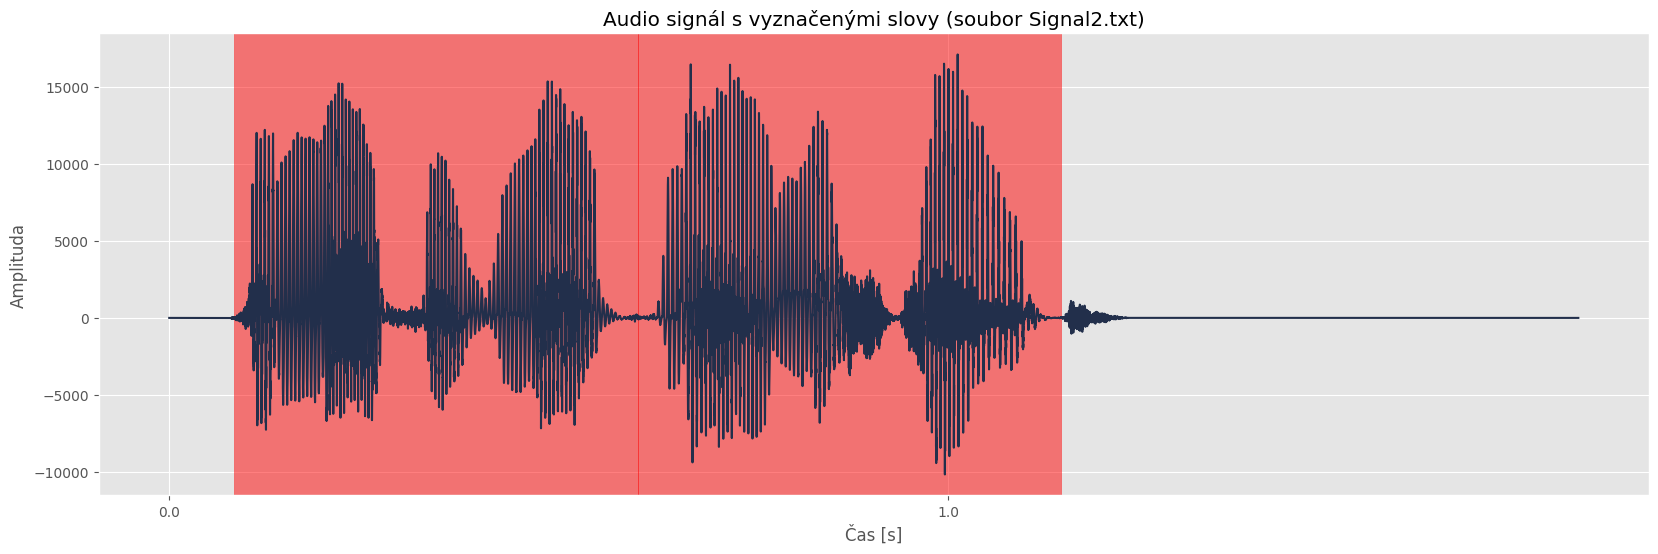

In [41]:
data = load_txt("Signal2.txt")
parts, regions = split_data(data, window_size=400,threshold=1200)

plt.figure(figsize=(20, 6))
plt.plot(data, color="#222F4B")
for i, (start, end) in enumerate(regions):
    color = "red"
    plt.axvspan(start, end, color=color, alpha=0.5) 
plt.xticks(np.arange(0, len(data), 22050), np.round(np.arange(0, len(data), 22050)/22050, 1))
plt.xlabel("Čas [s]")
plt.ylabel("Amplituda")
plt.title("Audio signál s vyznačenými slovy (soubor Signal2.txt)")
plt.show()

In [42]:
for Y in parts:
    similarities = []
    for (word, X, srX) in words:
        pX, pY = spad(X, Y)
        # Compute features for reference audio
        mfccsX, scX, chromaX = compute_audio_features(pX, srX)
        # Compute features for target audio
        mfccsY, scY, chromaY = compute_audio_features(pY, 22050)
        # Compute distances
        dist_mfccs = compute_spectral_distance(mfccsX, mfccsY)
        dist_sc = compute_spectral_distance(scX, scY)
        dist_chroma = compute_spectral_distance(chromaX, chromaY)
        #print(dist_mfccs, dist_sc, dist_chroma)
        # Combine distances with weights
        similarity = (dist_mfccs + dist_sc * 0.25 + dist_chroma * 0.1)
        similarities.append((word, similarity))
    
    print(*wstats(similarities))
    # Select the top 3 guesses
    guess = sorted(similarities, key=lambda x: x[1])[:3]
    guess = [(x[0], np.round(x[1], 2)) for x in guess]

('probable', 31.6) ('prepare', 30.7) ('idea', 28.0)
('disaster', 40.7) ('prepare', 26.5) ('give', 26.5)


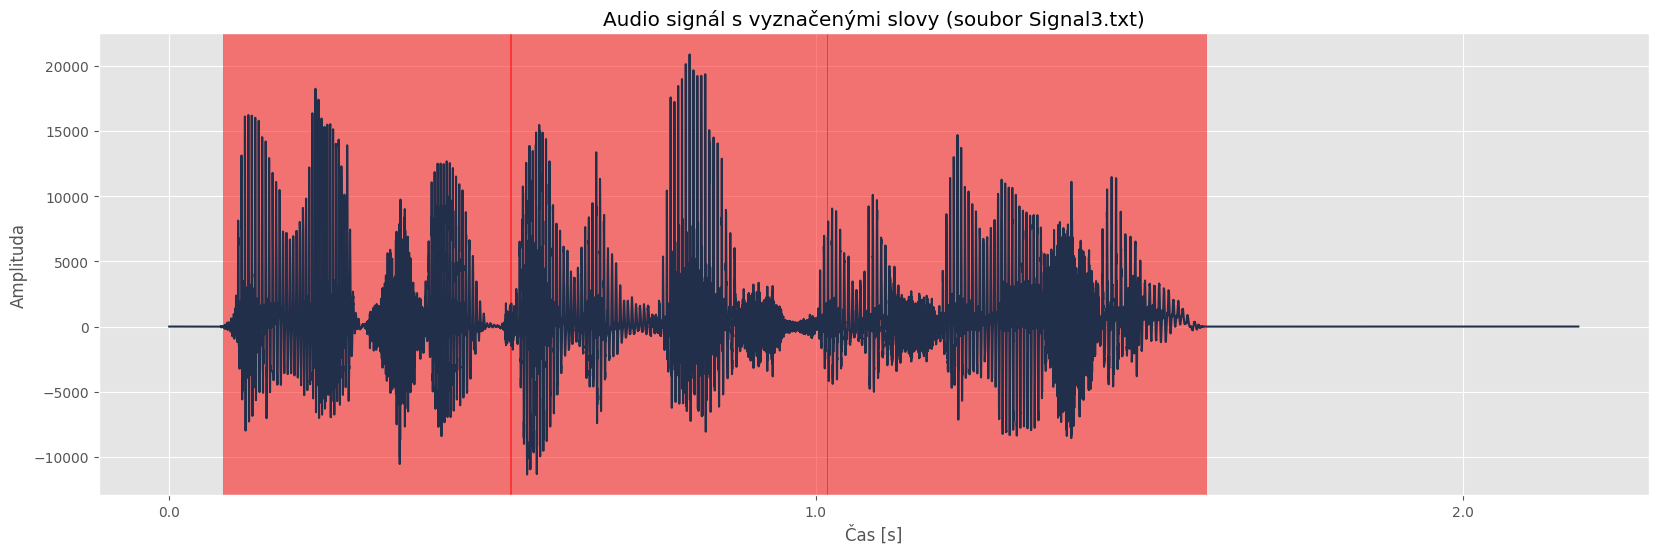

In [43]:
data = load_txt("Signal3.txt")
parts, regions = split_data(data, window_size=400,threshold=1200)

plt.figure(figsize=(20, 6))
plt.plot(data, color="#222F4B")
for i, (start, end) in enumerate(regions):
    color = "red"
    plt.axvspan(start, end, color=color, alpha=0.5) 
plt.xticks(np.arange(0, len(data), 22050), np.round(np.arange(0, len(data), 22050)/22050, 1))
plt.xlabel("Čas [s]")
plt.ylabel("Amplituda")
plt.title("Audio signál s vyznačenými slovy (soubor Signal3.txt)")
plt.show()

In [44]:
for Y in parts:
    similarities = []
    for (word, X, srX) in words:
        pX, pY = spad(X, Y)
        # Compute features for reference audio
        mfccsX, scX, chromaX = compute_audio_features(pX, srX)
        # Compute features for target audio
        mfccsY, scY, chromaY = compute_audio_features(pY, 22050)
        # Compute distances
        dist_mfccs = compute_spectral_distance(mfccsX, mfccsY)
        dist_sc = compute_spectral_distance(scX, scY)
        dist_chroma = compute_spectral_distance(chromaX, chromaY)
        #print(dist_mfccs, dist_sc, dist_chroma)
        # Combine distances with weights
        similarity = (dist_mfccs + dist_sc * 0.25 + dist_chroma * 0.1)
        similarities.append((word, similarity))
    
    print(*wstats(similarities))
    # Select the top 3 guesses
    guess = sorted(similarities, key=lambda x: x[1])[:3]
    guess = [(x[0], np.round(x[1], 2)) for x in guess]

('prepare', 32.3) ('method', 29.4) ('idea', 28.6)
('advice', 36.8) ('prepare', 27.5) ('method', 27.4)
('easy', 33.9) ('idea', 28.9) ('method', 27.8)
